In [25]:
import sys
sys.path.insert(0, '../python_dms/lib/')
from dms import *
from tools_dms import *
from PIL import Image
import scipy as scp

import scipy.io
import argparse
import os 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading image

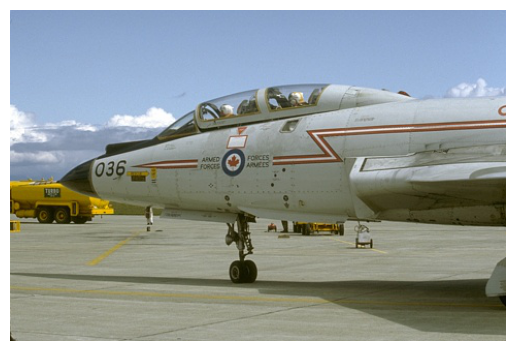

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


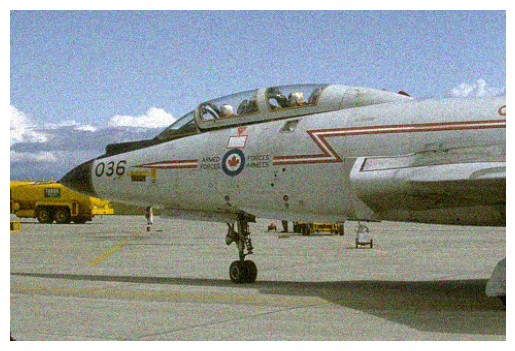

In [59]:
x = np.array(Image.open('../testset/10081.jpg'))/255.
plt.imshow(x)
plt.axis('off')
plt.show()


np.random.seed(0)
delta= 0.06
n = delta*np.random.normal(0,1,x.shape)
z= x+n

plt.imshow(z)
plt.axis('off')
plt.show()

## Parameters

In [64]:
# Blur or linear operators
otfA = np.ones((z.shape[0],z.shape[1]))

norm_type = 'l1'# 'AT-fourier'
method = 'SLPAM' # 'PALM', 'PALM-eps-descent', 'SLPAM-eps-descent'


beta= 10    #smoothing param
lambd = 0.02 #lenght contour param

# maximum iteration
mit =300


In [77]:
test = DMS(norm_type="l1",
        edges="similar",
        beta=3,
        lamb=6e-2,
        eps=0.2,
        stop_criterion=1e-4,
        MaximumIteration=10,
        method="SLPAM",
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-4,
        eps_AT_min=0.02,
        A=otfA)


Color image
Image is already in float [0,1] 



## Run

In [78]:
out_slpaml1 = test.process()

## Display results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


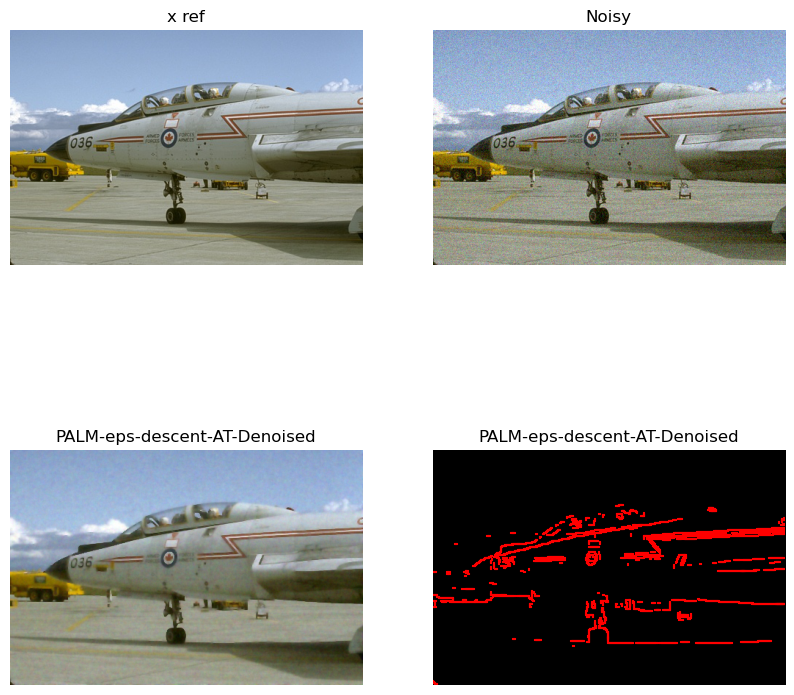

In [93]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(x)
plt.axis('off')
plt.title('x ref')
plt.subplot(222)
plt.imshow(z)
plt.axis('off')
plt.title('Noisy')
plt.subplot(223)
plt.imshow(out_slpaml1[1])
plt.axis('off')
plt.title(method+'-'+norm_type+'-'+'Denoised')
ax=plt.subplot(224)
plt.imshow(np.zeros((z.shape[0],z.shape[1])),cmap='gray')
draw_contour(out_slpaml1[0],'',fig=ax)
plt.axis('off')
plt.title(method+'-'+norm_type+'-'+'Denoised')
plt.show()

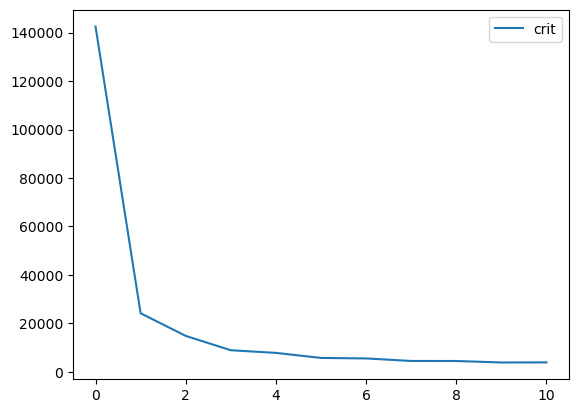

In [72]:
plt.figure()
plt.plot(out_slpaml1[2],label='crit')
plt.legend()
plt.show()

## Comparison between different methods

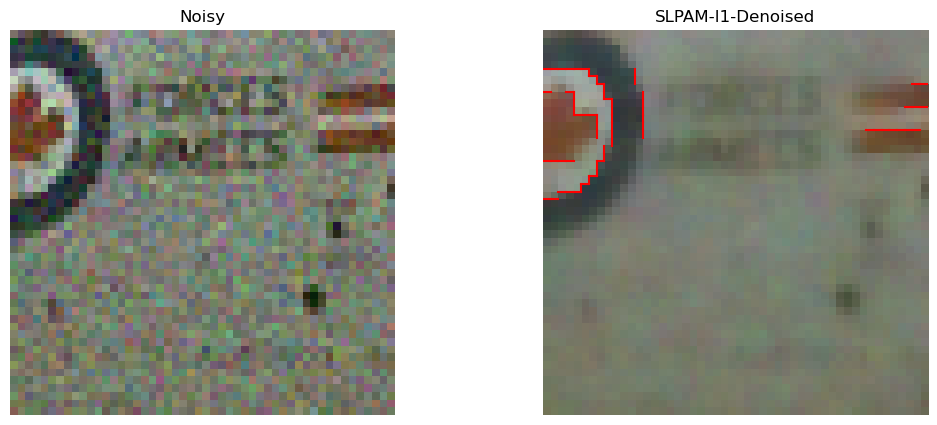

In [94]:
rows,cols = np.shape(z)[0],np.shape(z)[1]
sf=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1= plt.subplot(231)
ax1.imshow(z[rows//2-25:rows//2+25,cols//2-25:cols//2+25],cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax2=plt.subplot(232)
ax2.imshow(out_slpaml1[1][rows//2-25:rows//2+25,cols//2-25:cols//2+25],cmap='gray')
draw_contour(out_slpaml1[0][rows//2-25:rows//2+25,cols//2-25:cols//2+25],'',fig=ax2)
plt.axis('off')
plt.title('SLPAM'+'-'+'l1'+'-'+'Denoised')
plt.show()

In [75]:
z_crop = z[rows//2-25:rows//2+25,cols//2-25:cols//2+25]
A_crop = np.ones_like(z_crop)
norm_type = 'AT'
method = 'PALM-eps-descent'
# Ambrosio-Tortorelli paramters
eps = 0.5
# minimum eps AT in the case of descreasingepsilon 
eps_AT_min= 0.01

palm_AT_descent = DMS(norm_type=norm_type,
        edges="similar",
        beta=8,
        lamb=3e-2,
        eps=eps,
        stop_criterion=1e-4,
        MaximumIteration=10,
        method=method,
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-4,
        eps_AT_min=eps_AT_min,
        A=otfA)

out_palmAT_descent = palm_AT_descent.process()

Color image
Image is already in float [0,1] 

Epsilon:  0.5
Epsilon:  0.3333333333333333
Epsilon:  0.2222222222222222
Epsilon:  0.14814814814814814
Epsilon:  0.09876543209876543
Epsilon:  0.06584362139917695
Epsilon:  0.0438957475994513
Epsilon:  0.029263831732967534
Epsilon:  0.01950922115531169
Epsilon:  0.013006147436874461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


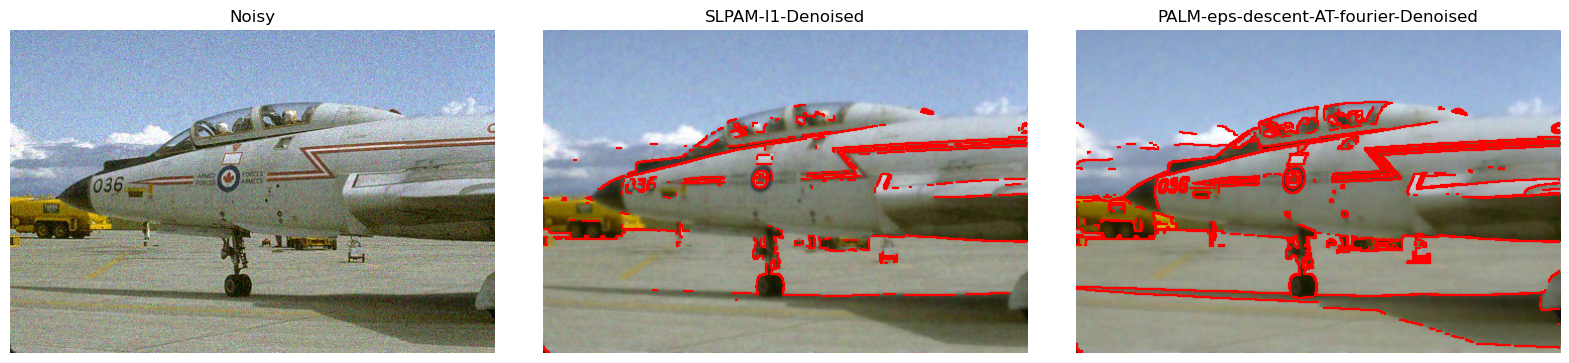

In [95]:


sf=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1= plt.subplot(231)
ax1.imshow(z,cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax2=plt.subplot(232)
ax2.imshow(out_slpaml1[1],cmap='gray')
draw_contour(out_slpaml1[0],'',fig=ax2)
plt.axis('off')
plt.title('SLPAM'+'-'+'l1'+'-'+'Denoised')
ax3=plt.subplot(233)
ax3.imshow(out_palmAT_descent[1],cmap='gray')
draw_contour(out_palmAT_descent[0],'',fig=ax2)
plt.axis('off')
plt.title('PALM-eps-descent'+'-'+ 'AT-fourier'+'-'+'Denoised')
plt.show()
